In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import mlflow
import mlflow.pytorch
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from utils.lstm_ativacao import LSTMAtivacao
from utils.carregar_modelo import carregar_modelo_completo
import os

### Challenge:

- predizer o valor de fechamento da bolsa de valores de uma empresa 
- pipeline de desenvolvimento:
    - criação do modelo preditivo
    - deploy do modelo em uma API que permita a previsão de preços de ações

In [3]:
# Set device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Dados históricos:

- techfase4\process\get_data.ipynb
- tensores não aceitam string nem datas
- organizando o dado por data

In [4]:
df0 = pd.read_pickle("../data/dados.pkl")
df0["Date"] = pd.to_datetime(df0["Date"])

In [5]:
df = df0.sort_values("Date")

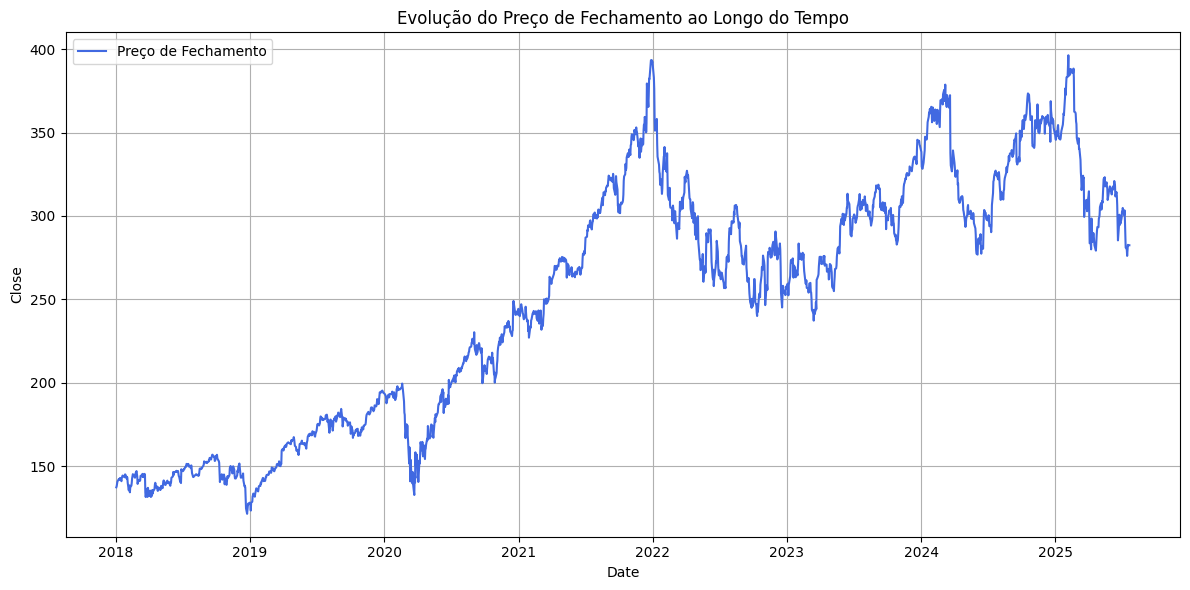

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Close"], label="Preço de Fechamento", color="royalblue")
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Evolução do Preço de Fechamento ao Longo do Tempo")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
df = df.drop(columns=["Date", 'Volume', 'Ticker'])

In [8]:
df.head()

,Close,High,Low,Open
0,137.391541,137.623750,136.444877,137.087896
1,138.025635,138.418592,136.632431,136.632431
2,139.659973,140.088648,138.222113,138.427517
3,140.812027,140.856684,139.436689,139.865364
4,141.937332,142.008780,140.070796,140.544128


### Criando sequências para LSTM:
- Modelos LSTM (Long Short-Term Memory) não aprendem apenas com os dados atuais, mas com janelas do passado.
- Eles precisam ver os últimos n passos no tempo para prever o próximo valor.
- A função create_sequences cria exatamente essas janelas.
- O tamanho da sequência: quantos passos de tempo o modelo vai olhar de uma vez. Ex: 120 dias passados do dado por input.

#### Primeira versão, construídos dois modelos para comparação, um normalizando os dados e outro não, mantendo a coluna 'Timestamp', desempenho obtido:

- Modelo normalizado:

MAE: 8.2709 | MSE: 123.0420

- Modelo sem notmalizacao: 

MAE: 62.2720 | MSE: 5120.9105

#### Teste 1

sequence_length = 120 

Melhor ativação: ReLU
🔹 MAE: 15.3568 | MSE: 382.5712


#### Teste 2
sequence_length = 100

Melhor ativação: ReLU
🔹 MAE: 14.5490 | MSE: 360.0348

#### Teste 3
sequence_length = 90

Melhor ativação: ReLU
🔹 MAE: 14.0789 | MSE: 346.4549

mesmo sequence mas aumentando epocas de 100 para 120

Melhor ativação: ReLU
🔹 MAE: 13.8487 | MSE: 332.0313

### Melhor opção época: 120 e sequence_length = 90

In [31]:
sequence_length = 90  # Length of the input sequences
forecast_horizon = 60 # Number of steps to forecast ahead

In [32]:
def create_sequences(data, sequence_length, forecast_horizon, target_index):
    X, y = [], []
    for i in range(len(data) - sequence_length - forecast_horizon + 1):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length:i+sequence_length+forecast_horizon, target_index])
    return np.array(X), np.array(y)

target_index = df.columns.get_loc("Close")
data_array = df.to_numpy()
X_seq, y_seq = create_sequences(data_array, sequence_length, forecast_horizon, target_index)

### Convertendo para tensores e DataLoader

In [33]:
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

O parâmetro input_size representa o número de features (variáveis independentes) em cada ponto da série temporal que está alimentando o modelo.

In [34]:
num_features = X_tensor.shape[2]
print("Number of features:", num_features)

Number of features: 4


In [35]:
df.shape

(1897, 4)

### LSTM

In [37]:
# Hyperparameters
input_size = X_tensor.shape[2]      # Number of features in the input data
hidden_size = 100     # Number of hidden units in the LSTM
num_layers = 2       # Number of LSTM layers
output_size = forecast_horizon     # prever 60 dias à frente
num_epochs = 120
batch_size = 64 # para cada epoca, qt de informação, não é um numero, tensor, cada informacao, 60 unidades de tempo
learning_rate = 0.001
num_samples = 10000  # Number of artificial samples to generate

### Testando 3 opções de ativações para escolher a melhor

In [38]:
ativacoes = {
    "ReLU": nn.ReLU(),
    "Tanh": nn.Tanh(),
    "Sem_Ativacao": nn.Identity()
}

### Classe criada em arquivo separado (lstm_ativacao.py) para ser também usada no app.py

In [39]:
def avaliar_modelo(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            output = model(X_batch).squeeze()
            y_true.extend(y_batch.numpy())
            y_pred.extend(output.numpy())

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    return y_true, y_pred, mae, mse

### Rodando o modelo com diferentes ativações

Treinando com ativação: ReLU
y_pred shape: (350, 60)
y_pred preview: [352.30054 351.64282 351.3856  350.92697 350.8925  350.50357 350.79852
 350.49295 350.46295 350.61868 350.3709  350.1139  349.93286 350.1483
 350.461   350.29544 350.39423 350.0585  349.7411  349.55368 349.7263
 349.4362  348.83575 348.91333 349.00223 348.7512  348.8551  348.59143
 348.8191  348.40396 347.44373 346.89514 346.59866 346.5537  346.13748
 345.3143  345.28748 344.98746 344.53763 343.681   343.36273 342.98007
 342.81793 342.38876 341.92767 341.6534  341.09177 341.09943 341.2609
 341.10635 341.07114 341.1586  340.692   341.0768  341.39606 340.73486
 341.25015 341.16605 341.3585  340.8071 ]
Valores únicos: [141.52682 141.5422  141.55443 ... 368.77484 368.92096 369.89313]


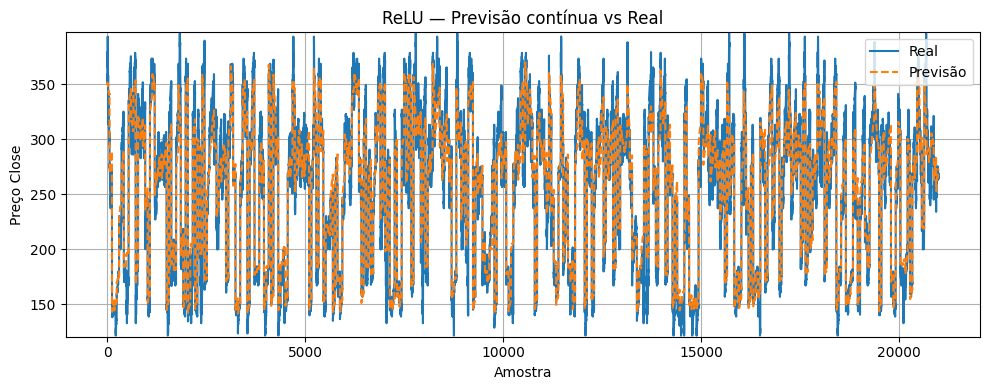

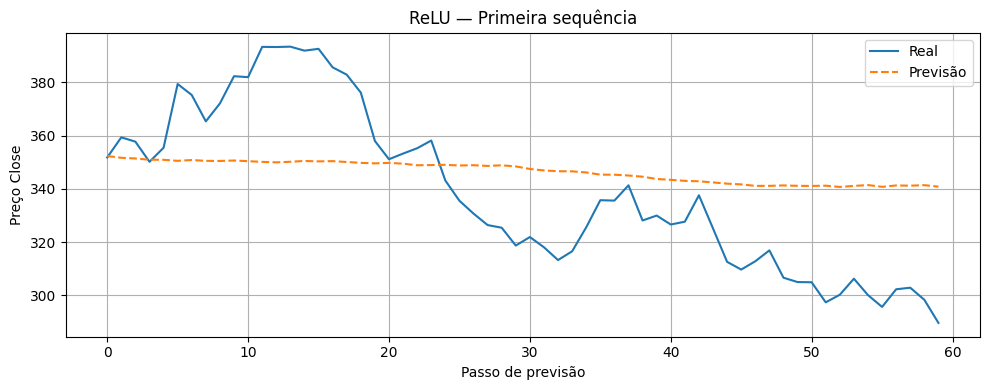

Treinando com ativação: Tanh
y_pred shape: (350, 60)
y_pred preview: [254.22887 254.23988 254.29068 254.36888 254.36707 254.51784 254.63388
 254.83827 254.95204 255.02242 255.13593 255.19565 255.24644 255.36902
 255.5015  255.63509 255.74963 255.8568  255.91583 256.04755 256.15424
 256.1753  256.24005 256.3961  256.52454 256.64764 256.80954 256.85886
 257.02975 257.1193  257.13715 257.1851  257.27823 257.33347 257.45343
 257.54147 257.74228 257.80548 257.73615 257.84436 257.95706 257.98123
 257.9937  258.01968 258.11102 258.1176  258.31262 258.3335  258.4641
 258.502   258.5319  258.61945 258.7095  258.82153 258.9223  258.94586
 258.98343 259.12207 259.17743 259.26273]
Valores únicos: [254.22884 254.22887 254.23984 254.23988 254.29068 254.2907  254.36707
 254.36711 254.36885 254.36888 254.51782 254.51784 254.63387 254.63388
 254.83824 254.83827 254.95204 254.95209 255.02237 255.02242 255.1359
 255.13593 255.19563 255.19565 255.24635 255.24644 255.36902 255.50148
 255.5015  255.63504 25

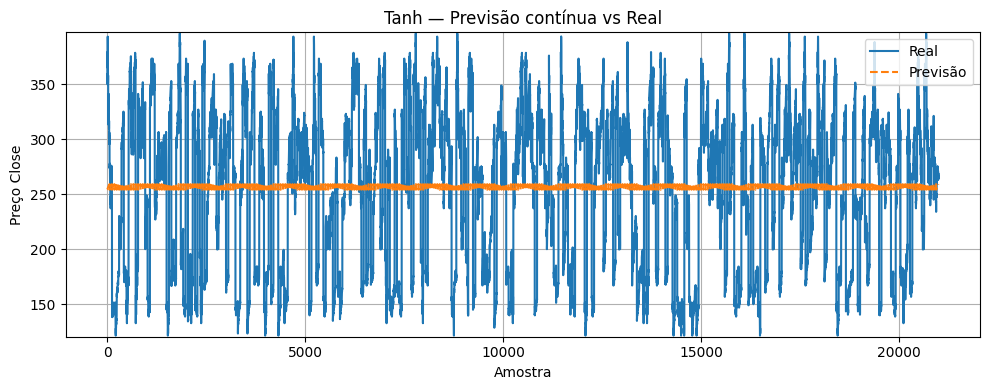

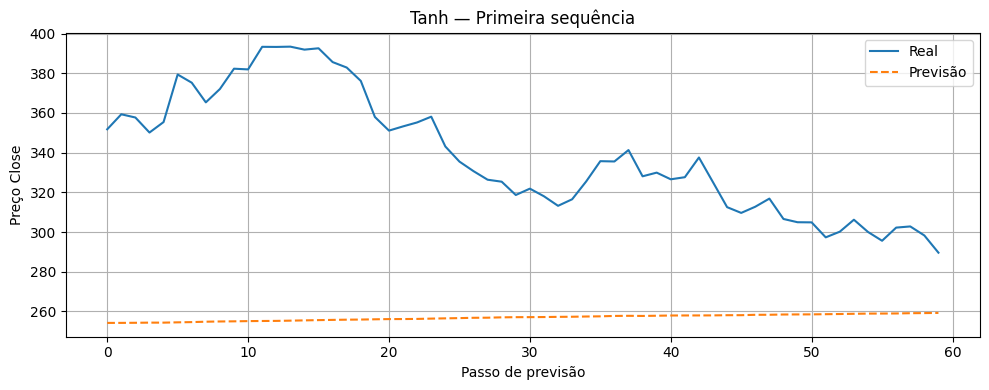

Treinando com ativação: Sem_Ativacao
y_pred shape: (350, 60)
y_pred preview: [351.76678 351.73105 351.98825 351.60077 351.00443 350.8959  350.81598
 350.93692 350.96118 350.85214 350.3616  350.3576  350.65274 350.96097
 351.43665 351.3425  351.174   350.90308 350.58167 351.68915 351.86005
 351.29434 351.45642 351.8866  350.75598 351.77472 351.6305  351.10413
 351.29813 350.57468 350.96323 350.17773 350.98932 350.1588  350.4532
 348.8668  349.84943 349.90283 348.41544 349.05658 348.2464  348.05865
 346.66556 348.10162 347.23462 347.51138 347.05762 346.95255 347.4735
 347.23257 346.88556 345.81604 345.6953  345.73645 345.3855  345.22736
 344.90677 344.70282 345.70145 345.43625]
Valores únicos: [141.5937  141.68202 141.69937 ... 354.80682 354.86435 354.90237]


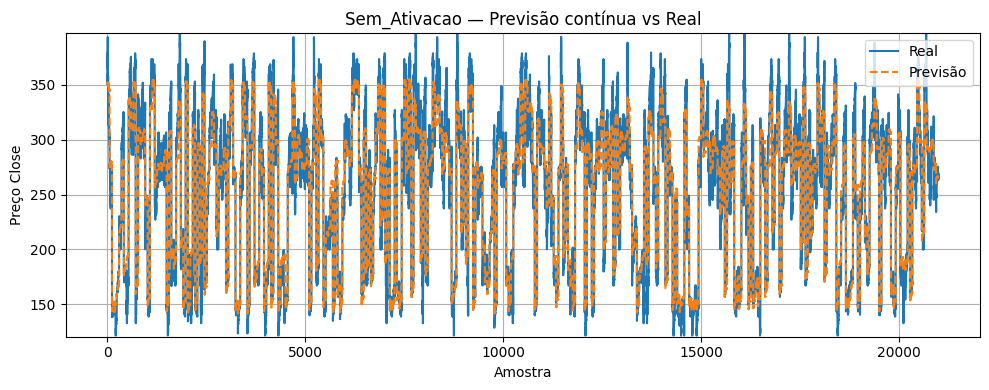

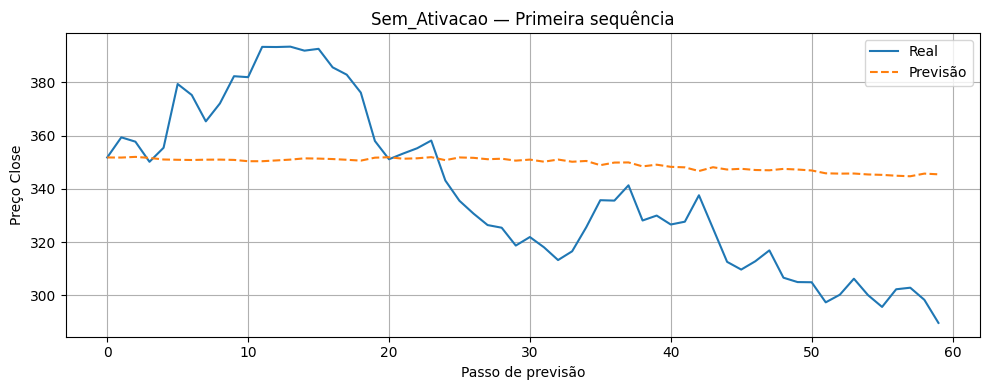

In [40]:
resultados = {}
modelos_salvos = {}

for nome, funcao in ativacoes.items():
    print(f"Treinando com ativação: {nome}")
    
    model = LSTMAtivacao(input_size, hidden_size, num_layers, output_size, funcao).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Início do experimento no MLflow
    mlflow.set_experiment("LSTM Artificial Data Regression")
    with mlflow.start_run(run_name=f"Ativação: {nome}"):
        # Log dos parâmetros
        mlflow.log_param("activation", nome)
        mlflow.log_param("input_size", input_size)
        mlflow.log_param("hidden_size", hidden_size)
        mlflow.log_param("num_layers", num_layers)
        mlflow.log_param("output_size", output_size)
        mlflow.log_param("num_epochs", num_epochs)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        
        # Treinamento
        for epoch in range(num_epochs):
            model.train()
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                pred = model(X_batch)
                loss = loss_fn(pred, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Avaliação sem scaler
        y_true, y_pred, mae, mse = avaliar_modelo(model, test_loader)
        resultados[nome] = {"MAE": mae, "MSE": mse}
        modelos_salvos[nome] = model.state_dict()

        # Diagnóstico rápido das previsões
        print("y_pred shape:", np.array(y_pred).shape)
        print("y_pred preview:", np.array(y_pred)[0])
        print("Valores únicos:", np.unique(np.array(y_pred)))

        # Log das métricas
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("MSE", mse)

       # Log do gráfico
        plt.figure(figsize=(10, 4))

        # Junta todas as previsões e reais em uma única sequência
        plt.plot(np.ravel(y_true), label="Real")
        plt.plot(np.ravel(y_pred), linestyle="--", label="Previsão")
        plt.title(f"{nome} — Previsão contínua vs Real")
        plt.xlabel("Amostra")
        plt.ylabel("Preço Close")
        plt.grid(True)

        # Zoom automático com leve folga
        plt.ylim(min(np.ravel(y_true)) - 1, max(np.ravel(y_true)) + 1)

        # Elimina duplicatas na legenda
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())

        plt.tight_layout()
        plt.show()

        # Visualização de uma única amostra
        plt.figure(figsize=(10, 4))
        plt.plot(y_true[0], label="Real")
        plt.plot(y_pred[0], linestyle="--", label="Previsão")
        plt.title(f"{nome} — Primeira sequência")
        plt.xlabel("Passo de previsão")
        plt.ylabel("Preço Close")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

### Avaliando o resultado

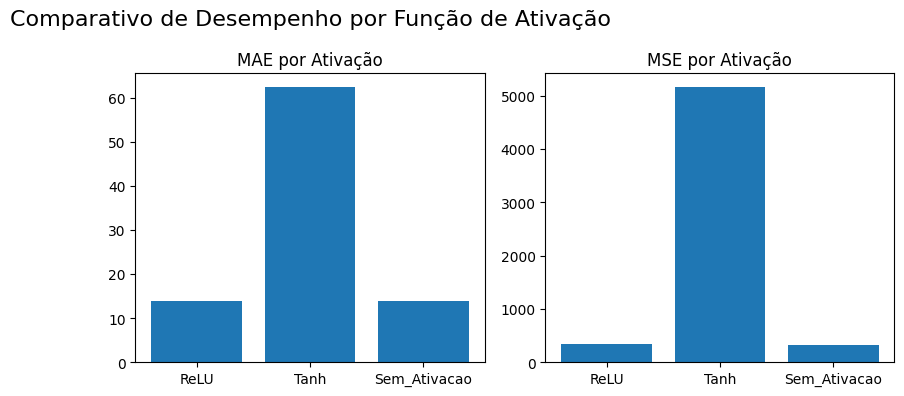

In [41]:
labels = list(resultados.keys())
mae_vals = [resultados[k]["MAE"] for k in labels]
mse_vals  = [resultados[k]["MSE"] for k in labels]

x = np.arange(len(labels))

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 2)
plt.bar(x, mae_vals, tick_label=labels)
plt.title("MAE por Ativação")

plt.subplot(1, 3, 3)
plt.bar(x, mse_vals, tick_label=labels)
plt.title("MSE por Ativação")

plt.suptitle("Comparativo de Desempenho por Função de Ativação", fontsize=16)
plt.tight_layout()
plt.show()

In [42]:
print("Modelos salvos disponíveis:", modelos_salvos.keys())

Modelos salvos disponíveis: dict_keys(['ReLU', 'Tanh', 'Sem_Ativacao'])


### Selecionado o melhor modelo

In [44]:
# Seleção do melhor modelo com base no menor MAE
melhor_ativacao = min(resultados, key=lambda k: resultados[k]["MAE"])
melhor_mae = resultados[melhor_ativacao]["MAE"]
melhor_mse = resultados[melhor_ativacao]["MSE"]

print(f"\n⭐ Melhor ativação: {melhor_ativacao}")
print(f"🔹 MAE: {melhor_mae:.4f} | MSE: {melhor_mse:.4f}")

# Carrega o modelo correspondente
melhor_modelo = LSTMAtivacao(input_size, hidden_size, num_layers, output_size, ativacoes[melhor_ativacao]).to(device)
melhor_modelo.load_state_dict(modelos_salvos[melhor_ativacao])
melhor_modelo.eval()



⭐ Melhor ativação: ReLU
🔹 MAE: 13.8487 | MSE: 332.0313


LSTMAtivacao(
  (lstm): LSTM(4, 100, num_layers=2, batch_first=True, dropout=0.2)
  (regressor): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=60, bias=True)
  )
)

### Fazendo novas previsões

In [45]:
steps_ahead = 60

In [46]:
def multi_step_forecast(model, last_sequence, steps_ahead=steps_ahead):
    """
    Gera previsão direta de até 60 dias com base na última sequência.
    """
    model.eval()
    steps_ahead = min(max(1, steps_ahead), 60)  # garante entre 1 e 60

    with torch.no_grad():
        out = model(last_sequence.unsqueeze(0))  # shape: (1, 60)
        preds = out.squeeze().cpu().numpy().tolist()

    return preds[:steps_ahead]

In [47]:
last_seq = X_tensor[-1]  # última sequência do dataset
multi_preds = multi_step_forecast(melhor_modelo, last_seq, steps_ahead)

In [48]:
close_index = df.columns.get_loc("Close")

In [49]:
# Última data conhecida dataset original
last_date = df0["Date"].max()  # ou df.index.max() se estiver no índice
last_date

Timestamp('2025-07-21 00:00:00')

In [50]:
# Número de passos previstos
steps_ahead = len(multi_preds)

# Gera as datas futuras
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps_ahead, freq='D')
future_dates = future_dates.strftime('%Y/%m/%d')


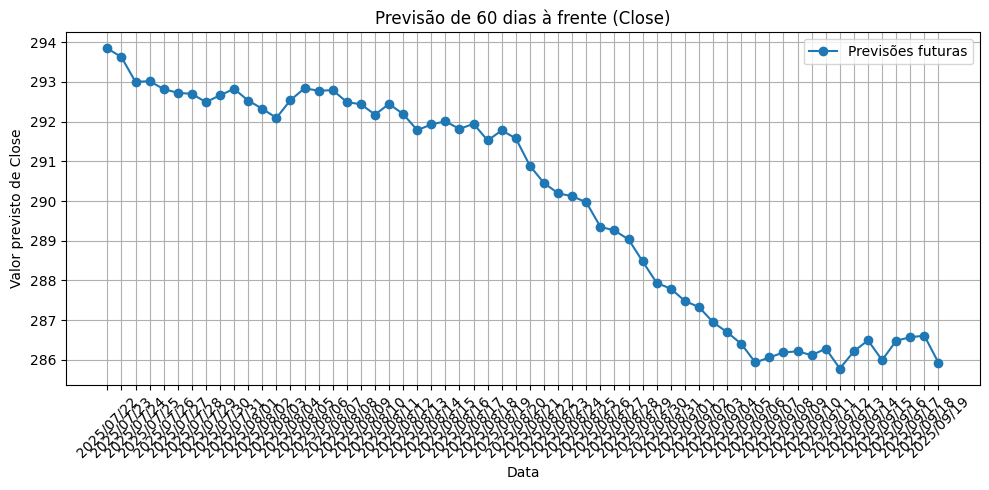

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(future_dates, multi_preds, marker='o', label="Previsões futuras")
plt.title(f"Previsão de {steps_ahead} dias à frente (Close)")
plt.xlabel("Data")
plt.ylabel("Valor previsto de Close")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Salvando o modelo

In [67]:
#torch.save(melhor_modelo.state_dict(), "modelo_lstm_v2.pth")

In [52]:
def salvar_modelo(model, input_size, hidden_size, num_layers, output_size,
                  ativacao_nome, sequence_length, caminho_modelo="modelo_lstm.pt"):
    # Salva o modelo e metadados
    torch.save({
        "model_state": model.state_dict(),
        "input_size": input_size,
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "output_size": output_size,
        "activation": ativacao_nome,
        "sequence_length": sequence_length
    }, caminho_modelo)

    print(f"Modelo salvo com sucesso: {caminho_modelo}")

In [53]:
salvar_modelo(
    model=melhor_modelo,
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    ativacao_nome=melhor_ativacao,
    sequence_length=sequence_length,
)

Modelo salvo com sucesso: modelo_lstm.pt


In [54]:
print("Modelo espera input_size =", melhor_modelo.lstm.input_size)

Modelo espera input_size = 4


In [ ]:
### Carregando o modelo salvo
# # Caminhos absolutos
# BASE_DIR = os.getcwd()
# model_path = os.path.join(BASE_DIR, "modelo_lstm.pt")
# scaler_path = os.path.join(BASE_DIR, "scaler.pkl")
# scaler_y_path = os.path.join(BASE_DIR, "scaler_y.pkl")

# # Carrega modelo e scalers
# model, scaler, scaler_y = carregar_modelo_completo(model_path, scaler_path, scaler_y_path)
# print(model_path)